In [3]:
# Day 2: Advanced Banking Analytics & Customer Segmentation
# BFSI Analytics Portfolio - KEDGE Business School
# Focus: Customer Intelligence, Risk Analysis, Business Insights

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('bank-additional-full.csv', sep=',')
print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")

Dataset loaded successfully!
Shape: (11162, 17)


In [5]:
# CUSTOMER SEGMENTATION ANALYSIS
print("=== CUSTOMER SEGMENTATION ANALYSIS ===\n")

# Create numerical features for clustering
df_numeric = df.copy()

# Convert categorical to numerical
df_numeric['deposit_num'] = df_numeric['deposit'].map({'yes': 1, 'no': 0})
df_numeric['housing_num'] = df_numeric['housing'].map({'yes': 1, 'no': 0})
df_numeric['loan_num'] = df_numeric['loan'].map({'yes': 1, 'no': 0})
df_numeric['default_num'] = df_numeric['default'].map({'yes': 1, 'no': 0})

# Select features for segmentation
features_for_clustering = ['age', 'balance', 'duration', 'campaign', 'deposit_num']
X = df_numeric[features_for_clustering].fillna(0)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['customer_segment'] = kmeans.fit_predict(X_scaled)

# Analyze segments
print("Customer Segments Analysis:")
segment_analysis = df.groupby('customer_segment').agg({
    'age': 'mean',
    'balance': 'mean',
    'duration': 'mean',
    'campaign': 'mean',
    'deposit': lambda x: (x == 'yes').mean() * 100
}).round(2)

segment_analysis.columns = ['Avg_Age', 'Avg_Balance', 'Avg_Call_Duration', 'Avg_Contacts', 'Success_Rate_%']
print(segment_analysis)

# Name the segments based on characteristics
segment_names = {
    0: 'Young_Savers',
    1: 'Mature_Investors', 
    2: 'Budget_Conscious',
    3: 'Premium_Clients'
}

df['segment_name'] = df['customer_segment'].map(segment_names)

=== CUSTOMER SEGMENTATION ANALYSIS ===

Customer Segments Analysis:
                  Avg_Age  Avg_Balance  Avg_Call_Duration  Avg_Contacts  \
customer_segment                                                          
0                   35.07      1227.08             586.84          2.06   
1                   40.08      1017.87             212.43          2.23   
2                   40.90      1157.17             219.49         12.64   
3                   59.17      3941.18             423.29          1.89   

                  Success_Rate_%  
customer_segment                  
0                          98.69  
1                           0.00  
2                          16.63  
3                          87.75  


In [9]:
# BUSINESS INTELLIGENCE METRICS
print("\n=== KEY BUSINESS INTELLIGENCE METRICS ===\n")

# 1. Customer Lifetime Value (CLV) Estimation
avg_deposit_value = 5000  # Assume average term deposit value
df['estimated_clv'] = df['balance'] * 0.02 + (df['deposit'] == 'yes').astype(int) * avg_deposit_value

# 2. Campaign ROI Analysis
cost_per_contact = 50  # Assume $50 per contact
df['campaign_cost'] = df['campaign'] * cost_per_contact
df['campaign_roi'] = np.where(df['deposit'] == 'yes', 
                             (avg_deposit_value - df['campaign_cost']) / df['campaign_cost'] * 100, 
                             -100)

# 3. Risk Score (based on defaults, loans, balance)
df['risk_score'] = (
    (df['default'] == 'yes').astype(int) * 0.4 +
    (df['loan'] == 'yes').astype(int) * 0.3 +
    (df['balance'] < 0).astype(int) * 0.3
) * 100

# Business Summary
print("Overall Campaign Performance:")
total_customers = len(df)
successful_campaigns = (df['deposit'] == 'yes').sum()
total_cost = df['campaign_cost'].sum()
total_revenue = successful_campaigns * avg_deposit_value

print(f"• Total Customers: {total_customers:,}")
print(f"• Successful Conversions: {successful_campaigns:,}")
print(f"• Success Rate: {(successful_campaigns/total_customers)*100:.2f}%")
print(f"• Total Campaign Cost: ${total_cost:,}")
print(f"• Total Revenue Generated: ${total_revenue:,}")
print(f"• Overall ROI: {((total_revenue-total_cost)/total_cost)*100:.2f}%")

# Best performing segments
print(f"\nTop Performing Customer Segments:")
segment_performance = df.groupby('segment_name').agg({
    'deposit': lambda x: (x == 'yes').mean() * 100,
    'estimated_clv': 'mean',
    'campaign_roi': 'mean'
}).round(2)
print(segment_performance.sort_values('deposit', ascending=False))


=== KEY BUSINESS INTELLIGENCE METRICS ===

Overall Campaign Performance:
• Total Customers: 11,162
• Successful Conversions: 5,289
• Success Rate: 47.38%
• Total Campaign Cost: $1,399,950
• Total Revenue Generated: $26,445,000
• Overall ROI: 1789.00%

Top Performing Customer Segments:
                  deposit  estimated_clv  campaign_roi
segment_name                                          
Young_Savers        98.69        4959.03       6587.36
Premium_Clients     87.75        4466.27       6236.82
Budget_Conscious    16.63         854.47         42.36
Mature_Investors     0.00          20.36       -100.00


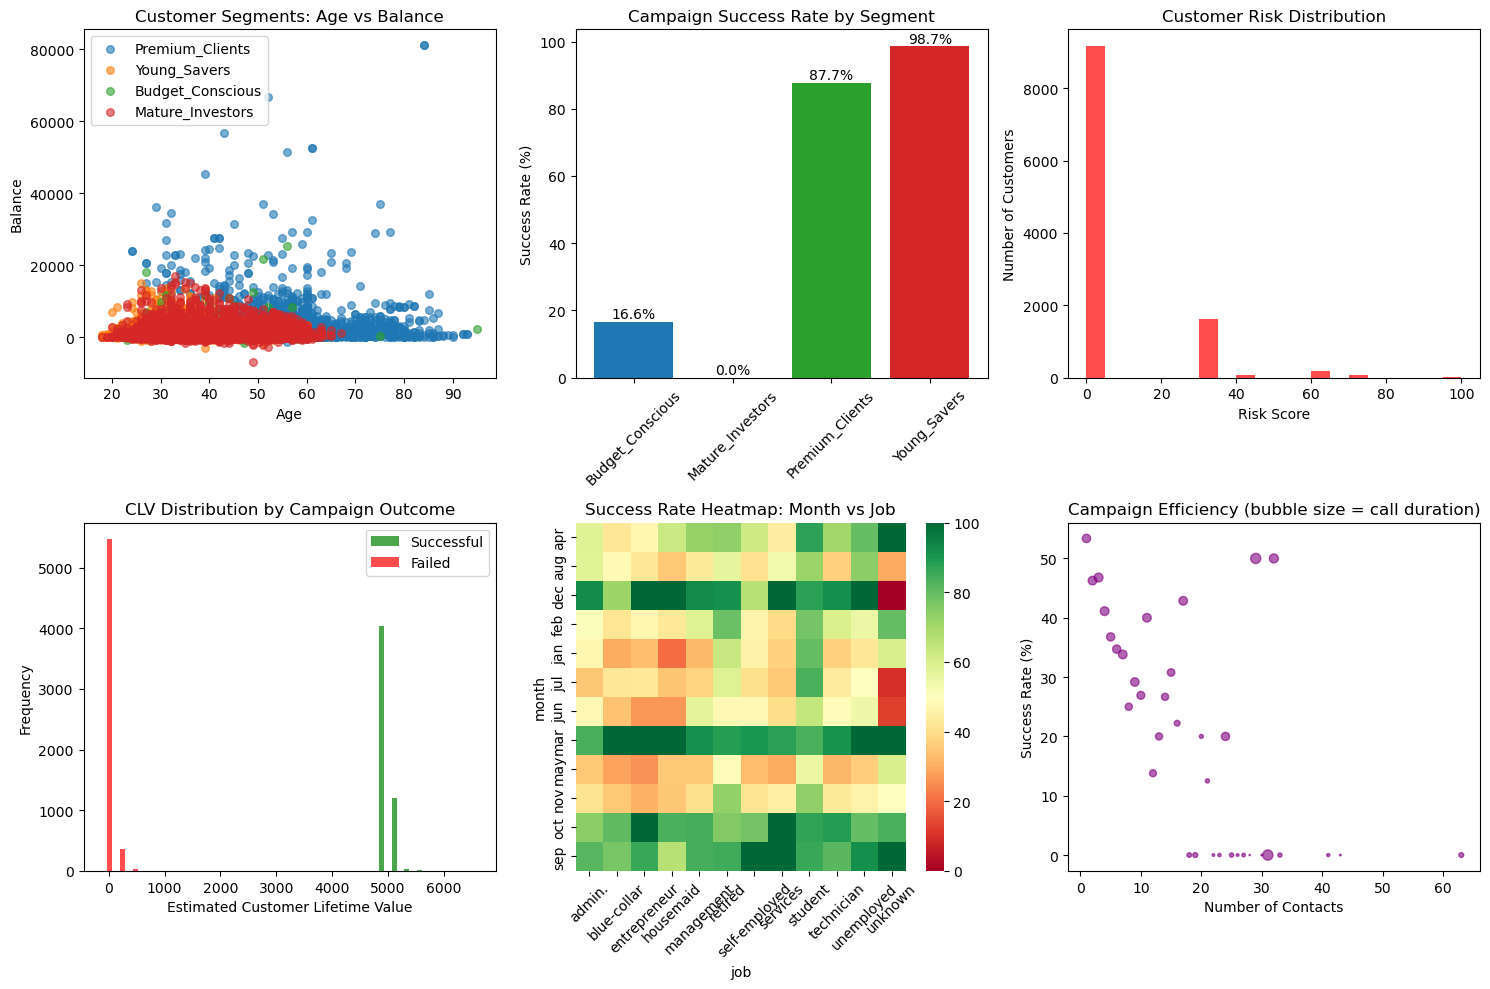

In [11]:
# ADVANCED VISUALIZATIONS FOR BUSINESS INSIGHTS

# 1. Customer Segmentation Visualization
plt.figure(figsize=(15, 10))

# Subplot 1: Age vs Balance by Segment
plt.subplot(2, 3, 1)
for segment in df['segment_name'].unique():
    segment_data = df[df['segment_name'] == segment]
    plt.scatter(segment_data['age'], segment_data['balance'], 
               label=segment, alpha=0.6, s=30)
plt.xlabel('Age')
plt.ylabel('Balance')
plt.title('Customer Segments: Age vs Balance')
plt.legend()

# Subplot 2: Success Rate by Segment
plt.subplot(2, 3, 2)
segment_success = df.groupby('segment_name')['deposit'].apply(lambda x: (x=='yes').mean()*100)
bars = plt.bar(segment_success.index, segment_success.values, 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Campaign Success Rate by Segment')
plt.ylabel('Success Rate (%)')
plt.xticks(rotation=45)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{segment_success.values[i]:.1f}%', ha='center')

# Subplot 3: Risk Distribution
plt.subplot(2, 3, 3)
plt.hist(df['risk_score'], bins=20, alpha=0.7, color='red')
plt.xlabel('Risk Score')
plt.ylabel('Number of Customers')
plt.title('Customer Risk Distribution')

# Subplot 4: CLV Distribution by Success
plt.subplot(2, 3, 4)
successful = df[df['deposit'] == 'yes']['estimated_clv']
failed = df[df['deposit'] == 'no']['estimated_clv']
plt.hist([successful, failed], bins=30, alpha=0.7, 
         label=['Successful', 'Failed'], color=['green', 'red'])
plt.xlabel('Estimated Customer Lifetime Value')
plt.ylabel('Frequency')
plt.title('CLV Distribution by Campaign Outcome')
plt.legend()

# Subplot 5: Monthly Performance Heatmap
plt.subplot(2, 3, 5)
monthly_job_success = df.groupby(['month', 'job'])['deposit'].apply(lambda x: (x=='yes').mean()*100).unstack()
sns.heatmap(monthly_job_success.fillna(0), cmap='RdYlGn', annot=False, fmt='.1f')
plt.title('Success Rate Heatmap: Month vs Job')
plt.xticks(rotation=45)

# Subplot 6: Campaign Efficiency
plt.subplot(2, 3, 6)
efficiency = df.groupby('campaign').agg({
    'deposit': lambda x: (x=='yes').mean()*100,
    'duration': 'mean'
}).reset_index()
plt.scatter(efficiency['campaign'], efficiency['deposit'], 
           s=efficiency['duration']/10, alpha=0.6, color='purple')
plt.xlabel('Number of Contacts')
plt.ylabel('Success Rate (%)')
plt.title('Campaign Efficiency (bubble size = call duration)')

plt.tight_layout()
plt.show()

In [13]:
# PREPARE DATA FOR POWER BI
print("\n=== PREPARING DATA FOR POWER BI ===")

# Create summary tables for Power BI
# 1. Customer Summary Table
customer_summary = df[['age', 'job', 'marital', 'education', 'balance', 
                      'housing', 'loan', 'deposit', 'customer_segment', 
                      'segment_name', 'estimated_clv', 'risk_score', 
                      'campaign_cost', 'campaign_roi']].copy()

# 2. Segment Performance Table
segment_summary = df.groupby('segment_name').agg({
    'age': 'mean',
    'balance': 'mean',
    'estimated_clv': 'mean',
    'risk_score': 'mean',
    'deposit': lambda x: (x == 'yes').mean() * 100,
    'campaign_cost': 'mean',
    'campaign_roi': 'mean'
}).round(2).reset_index()

# 3. Monthly Performance Table
monthly_summary = df.groupby(['month', 'segment_name']).agg({
    'deposit': lambda x: (x == 'yes').mean() * 100,
    'estimated_clv': 'mean',
    'campaign_cost': 'sum'
}).round(2).reset_index()

# Export to CSV for Power BI
customer_summary.to_csv('customer_data_for_powerbi.csv', index=False)
segment_summary.to_csv('segment_performance.csv', index=False)
monthly_summary.to_csv('monthly_performance.csv', index=False)

print("✅ Data exported for Power BI:")
print("• customer_data_for_powerbi.csv")
print("• segment_performance.csv") 
print("• monthly_performance.csv")
print("\nReady for Power BI dashboard creation!")


=== PREPARING DATA FOR POWER BI ===
✅ Data exported for Power BI:
• customer_data_for_powerbi.csv
• segment_performance.csv
• monthly_performance.csv

Ready for Power BI dashboard creation!
